# Introduction

---



This project is an exploration of the use of **AutoML tools** to solve **time series forecasting** problems.

**Forecasting**, or predicting the future value of a variable based on time series data, benefits many real-world business sectors. Its implementation can easily be found in various areas around us, such as weather prediction, stock market forecasting, and sales prediction. However, time series modeling is complex and differs from other machine learning problems, such as classification or regression.

**AutoML** stands for automatic machine learning (ML). Generally, these tools automate tasks such as model selection and hyperparameter tuning, making these processes significantly less tedious. There are drawbacks to using AutoML, such as limited flexibility in tweaking the models. However, it is an excellent tool for prototyping and validating that the dataset is not just noise.

This project is focusing on these AutoML tools for time-series forecasting:
- [AutoTS](https://winedarksea.github.io/AutoTS/build/html/source/tutorial.html), focusing on classical and traditional machine learning methods,
- [GCP AutoML](https://cloud.google.com/vertex-ai/docs/tabular-data/forecasting/overview), cloud-based solutions.

For each AutoML tools, we can evaluate their performance, ease of use, interpretability, and robustness.

**Keywords:** time series, forecasting, automl

## Dataset

This project uses a **daily commodity price dataset** from several cities in East Java, covering the time period from January 2018 to July 2024.

The chosen commodity is **shallot**, as it is a staple ingredient and the prices can fluctuate to more than triple the average.

This project will focus on **two regions: Mojokerto and Surabaya**. These regions represent smaller city (Mojokerto) and a major consumer market (Surabaya), respectively.

The data is obtained from [SISKAPERBAPO Jatim](https://siskaperbapo.jatimprov.go.id/) website.

In [ ]:
!python -m pip install numpy scipy scikit-learn seaborn statsmodels lightgbm xgboost numexpr bottleneck yfinance pytrends fredapi --exists-action i
!python -m pip install pystan prophet --exists-action i
!python -m pip install tensorflow
!python -m pip install mxnet --no-deps
!python -m pip install gluonts arch
!python -m pip install holidays-ext pmdarima dill greykite --exists-action i --no-deps
!python -m pip install autots --exists-action i
!pip install neuralprophet
!pip install pytorch torchvision torchaudio cpuonly
!pip install pytorch-forecasting

# Exploratory Data Analysis


---




In [2]:
from google.cloud import storage

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
import time
import csv
import os
import io

In [3]:
# Helper functions

def download_csv_from_gcs(bucket, file_name,
                          date_columns=None, col_names=None):
    """ A function to download dataset from GCS. """

    blob = bucket.blob(file_name)
    data = blob.download_as_text()
    df = pd.read_csv(io.StringIO(data),
                     parse_dates=date_columns,
                     usecols=col_names)
    return df

def upload_csv_to_gcs(df, bucket, file_path, sep=','):
    """ A function to upload dataset to GCS. """

    csv_buffer = io.StringIO()
    df.to_csv(csv_buffer, index=False, quoting=csv.QUOTE_ALL, encoding='utf-8')

    blob = bucket.blob(file_path)
    blob.upload_from_string(csv_buffer.getvalue(), content_type='text/csv')

    print(f"Successfully uploaded: '{blob.name}' to '{bucket.name}'")

In [5]:
# Create a client GCS and get the specified bucket
client = storage.Client()
bucket = client.get_bucket(BUCKET_NAME)

In [6]:
prices_df = download_csv_from_gcs(bucket, PRICES_CSV, date_columns=["date"])

In [7]:
# We can take a look at the shallot price dataset, which has a daily frequency
prices_df.groupby(["data_split", "regions"]).head(2)

date data_split    regions  price
0    2018-01-01      TRAIN  mojokerto  14750
1    2018-01-02      TRAIN  mojokerto  14750
2374 2024-07-02   VALIDATE  mojokerto  26500
2375 2024-07-03   VALIDATE  mojokerto  24250
2389 2024-07-17       TEST  mojokerto  22412
2390 2024-07-18       TEST  mojokerto  22412
2404 2018-01-01      TRAIN   surabaya  20000
2405 2018-01-02      TRAIN   surabaya  19800
4778 2024-07-02   VALIDATE   surabaya  29666
4779 2024-07-03   VALIDATE   surabaya  29333
4793 2024-07-17       TEST   surabaya  26333
4794 2024-07-18       TEST   surabaya  23333

We can check the dataset's timestamps. The `TRAIN` set contains approximately four years and 6 months of data, while both the `TEST` and `VALIDATE` sets include three months of data each.

In [8]:
# check the min/max date of each sets
prices_df.groupby(["data_split", "regions"])["date"].agg(["min", "max"])

min        max
data_split regions                        
TEST       mojokerto 2024-07-17 2024-07-31
           surabaya  2024-07-17 2024-07-31
TRAIN      mojokerto 2018-01-01 2024-07-01
           surabaya  2018-01-01 2024-07-01
VALIDATE   mojokerto 2024-07-02 2024-07-16
           surabaya  2024-07-02 2024-07-16

In [9]:
# check the rows count of each sets
prices_df.groupby(["data_split", "regions"])["price"].count()

data_split  regions  
TEST        mojokerto      15
            surabaya       15
TRAIN       mojokerto    2374
            surabaya     2374
VALIDATE    mojokerto      15
            surabaya       15
Name: price, dtype: int64

In [10]:
train_start = prices_df[prices_df["data_split"] == "TRAIN"]["date"].min()
train_end = prices_df[prices_df["data_split"] == "TRAIN"]["date"].max()

val_start = prices_df[prices_df["data_split"] == "VALIDATE"]["date"].min()
val_end = prices_df[prices_df["data_split"] == "VALIDATE"]["date"].max()

test_start = prices_df[prices_df["data_split"] == "TEST"]["date"].min()
test_end = prices_df[prices_df["data_split"] == "TEST"]["date"].max()

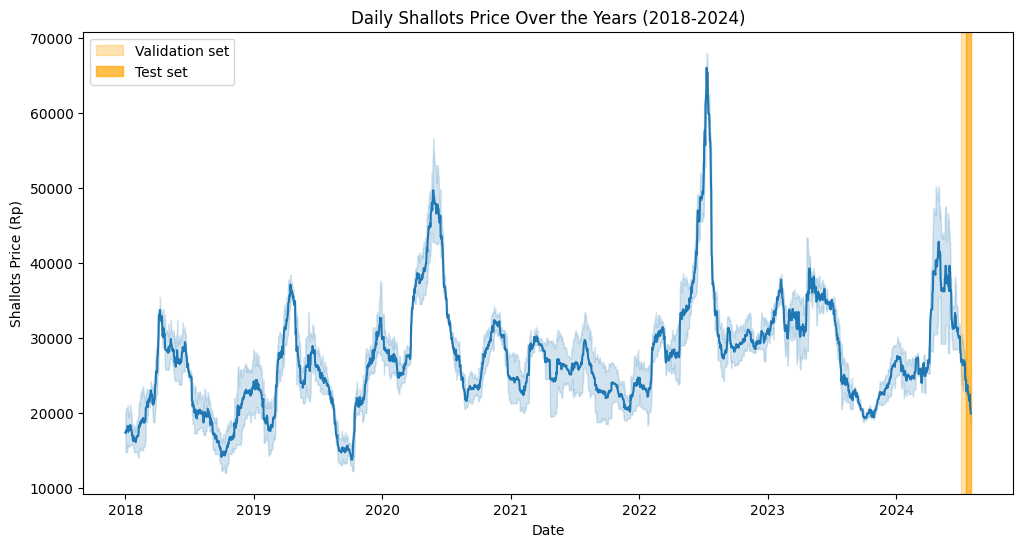

In [11]:
# Plot the daily shallot prices to see the fluctuation and data partition
# to train, val, and test

plt.figure(figsize=(12, 6))
sns.lineplot(prices_df, x="date", y="price")

# Mark the validation timestamp
plt.axvspan(pd.to_datetime(val_start), pd.to_datetime(val_end),
            color="orange", alpha=0.3, label="Validation set")

# Mark the test timestamp
plt.axvspan(pd.to_datetime(test_start), pd.to_datetime(test_end),
            color="orange", alpha=0.7, label="Test set")

plt.xlabel("Date")
plt.ylabel("Shallots Price (Rp)")
plt.title("Daily Shallots Price Over the Years (2018-2024)")
plt.legend()
plt.show()

From the plot above, we can observe that the price trend tends to peak at the beginning of the year and declines in the second half. However, we notice that the seasonal pattern is not very strong in our dataset, especially in the year 2021.

We can see the price distribution for each month throughout the year in the plot below.

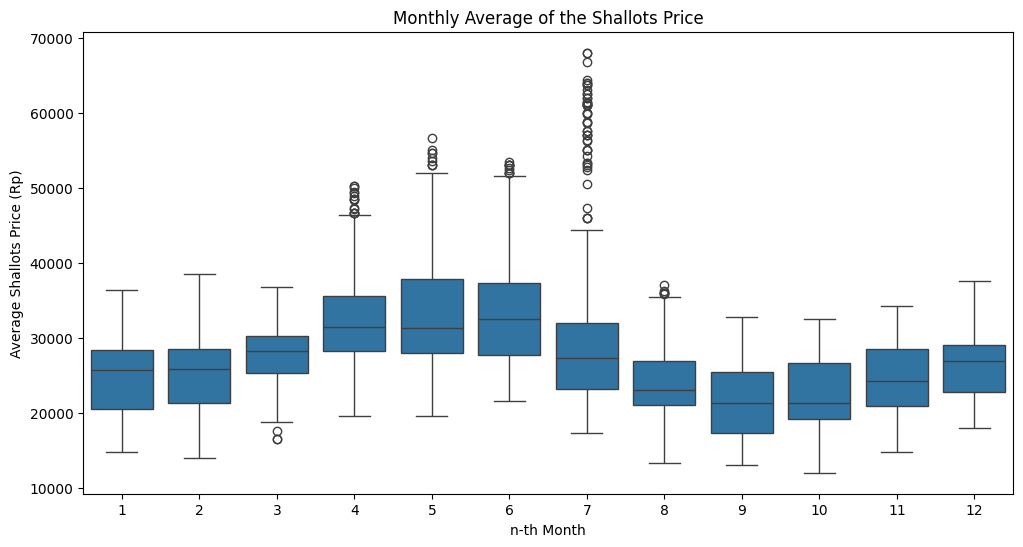

In [12]:
plt.figure(figsize=(12, 6))

sns.boxplot(prices_df, x=prices_df["date"].dt.month, y="price")

plt.xlabel("n-th Month")
plt.ylabel("Average Shallots Price (Rp)")
plt.title("Monthly Average of the Shallots Price")
plt.show()

Then, we can examine the statistics of shallot prices.

In [13]:
prices_df[["regions", "price"]].groupby(["regions"]).agg(
    ["median", "mean", "std", "min", "max"]
)

price                                         
            median          mean          std    min    max
regions                                                    
mojokerto  24250.0  25136.561980  7089.663609  12000  68000
surabaya   29000.0  29622.760399  7465.056849  14600  64400

And, we can also check the prices histogram.

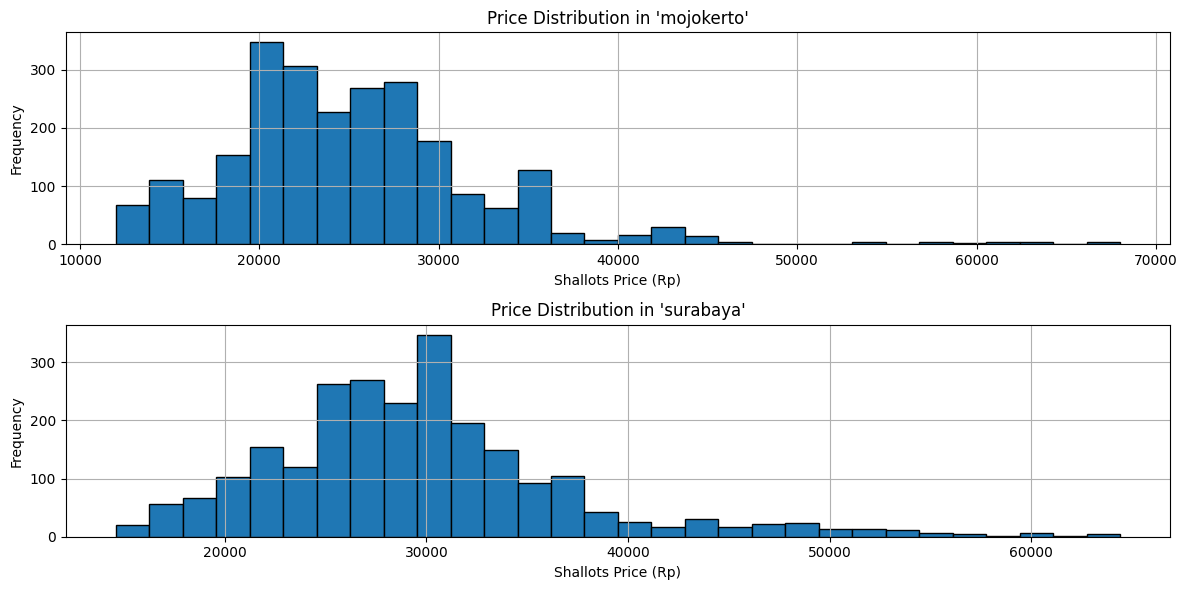

In [14]:
regions = prices_df["regions"].unique()

fig, ax = plt.subplots(len(regions), 1, figsize=(12, 6))
for i, region in enumerate(regions):
    prices_df[prices_df["regions"] == region]["price"].hist(bins=30,
                                                            edgecolor="black",
                                                            ax=ax[i])

    ax[i].set_title(f"Price Distribution in '{region}'")
    ax[i].set_xlabel("Shallots Price (Rp)")
    ax[i].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

As we can observe from the plots and data statistics, the daily shallot prices fluctuate significantly over time.

# Feature Engineering

---



Now that we have observed price fluctuations, we need to collect additional features to help our model accurately predict future shallot prices in the market.

These additional features include:
- time-related feature,
- holiday-proximity feature, and
- weather feature.

In [15]:
feat_df = prices_df.copy()

## Time-related features

We can add time-related features to capture **seasonality** in our dataset.

Tools like GCP AutoML support the automatic inclusion of date features, while AutoTS requires date features to be added manually. Therefore, we will add multiple time-related features to our dataset.

However, instead of adding straight-forward time features such as day, month, and year, we can encode these features using **sine and cosine transformations**. This approach is commonly used in time series forecasting, as these transformations provide a **continuous representation** of cyclical time patterns.

For a given $t$ time feature that has a $T$ period:

$$ \text{sin_t} = \sin \left( \frac{2 \pi t}{T} \right), $$
$$ \text{cos_t} = \cos \left( \frac{2 \pi t}{T} \right), $$

which in our case, $T$ is equal to 365.

In [16]:
# Add day of year as a time feature
feat_df["dayofyear"] = feat_df["date"].dt.dayofyear

# Apply sine and cosine transformations with period 365
T = 365
feat_df["featd_dayofyear_sin"] = np.sin(2 * np.pi * feat_df["dayofyear"] / T)
feat_df["featd_dayofyear_cos"] = np.cos(2 * np.pi * feat_df["dayofyear"] / T)

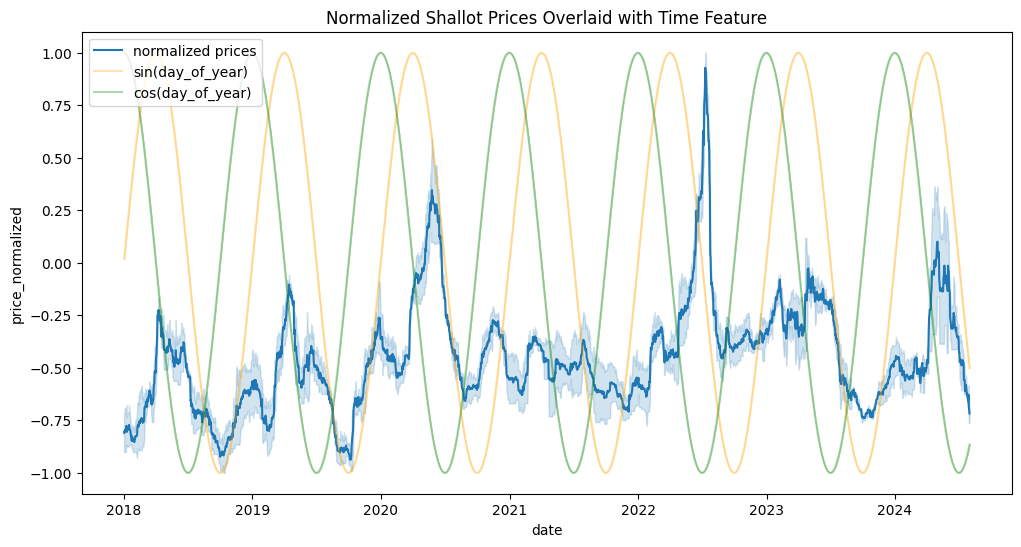

In [17]:
# Plot the time features with the normalized prices
plt.figure(figsize=(12, 6))

# Normalize the prices to (-1, 1) to match the value range of sin(t) and cos(t)
min, max = feat_df["price"].min(), feat_df["price"].max()
feat_df["price_normalized"] = 2 * (feat_df["price"] - min) / (max - min) - 1

# Plot the prices
sns.lineplot(feat_df, x="date", y="price_normalized", label="normalized prices")

# Plot the time features
sns.lineplot(feat_df, x="date", y="featd_dayofyear_sin",
             alpha=0.3, color="orange", label="sin(day_of_year)")
sns.lineplot(feat_df, x="date", y="featd_dayofyear_cos",
             alpha=0.3, color="green", label="cos(day_of_year)")

plt.title("Normalized Shallot Prices Overlaid with Time Feature")
plt.legend(loc="upper left")
plt.show()

We can see from the plot above that our time feature is encoded as intended.

## Holiday-proximity feature

There one more factor that we think can cause fluctuations in commodity prices, which is holidays.

The demand for certain commodities can spike during holiday periods, leading to an increase in prices. For instance, around occasions like Eid al-Fitr, Eid al-Adha, Christmas, and New Year, we often observe a rise in commodity prices.

However, instead of using a binary flag for holidays (like 0 or 1 for one-hot encoding), we decided to add a **holiday proximity feature**, where we encode proximity using a Gaussian function with a **15-day window size**. This allows the proximity value to gradually increase until it peaks on the holiday and then gradually decrease afterward.

The [Gaussian function](https://upload.wikimedia.org/wikipedia/commons/thumb/7/74/Normal_Distribution_PDF.svg/360px-Normal_Distribution_PDF.svg.png) has a bell-shaped curve and is commonly used to measure the proximity to a specific point. In this problem, it is defined as:

$$f(t_{\pm w}, t) = exp \left( -\frac{\| t_{\pm w}-t \|^2}{2 \sigma^2}  \right),$$

where $t_{\pm w}$ represents the days before or after the holiday, and $t$ is the holiday itself. The $\sigma^2$ is the variance of the Gaussian function, which in this case defined as $\text{window_size}/2$ to make sure that the function taper gradually to zero.

We use the Python library [holidays](https://pypi.org/project/holidays/) to check the holidays.

In [18]:
import holidays

id_holidays = holidays.ID()

In [19]:
# Helper function

def encode_holidays(name):
    """ To make the holidays as 1 and regular days as 0 """

    # Encode None as 'regular day' and exclude the 'second day' holidays
    if not name or "second day" in name:
        return False
    return True

def calc_holiday_proximity(dates, holiday_dates, window_size=15):
    """ Calculate the proximity to a holiday from current date """

    feat_df["feath_proximity"] = 0.0

    for holiday in holiday_dates:
        for w_i in range(-window_size, window_size + 1):
            w_date = holiday + pd.Timedelta(days=w_i)

            # Apply Gaussian function
            if w_date in feat_df["date"].values:
                feat_df.loc[feat_df["date"] == w_date, "feath_proximity"] \
                    += np.exp(-0.5 * (w_i / (window_size / 2))**2)

    # Clip the maximum value to 1 in the case of holidays in the close vicinity
    feat_df["feath_proximity"] = feat_df["feath_proximity"].clip(upper=1)

    return feat_df

In [20]:
# Get the holiday dates
holiday_flags = feat_df["date"].apply(lambda x: encode_holidays(id_holidays.get(x)))
holiday_dates = feat_df.loc[holiday_flags, "date"].unique()

In [21]:
# Calculate the holiday proximity feature
feat_df = calc_holiday_proximity(feat_df, holiday_dates)

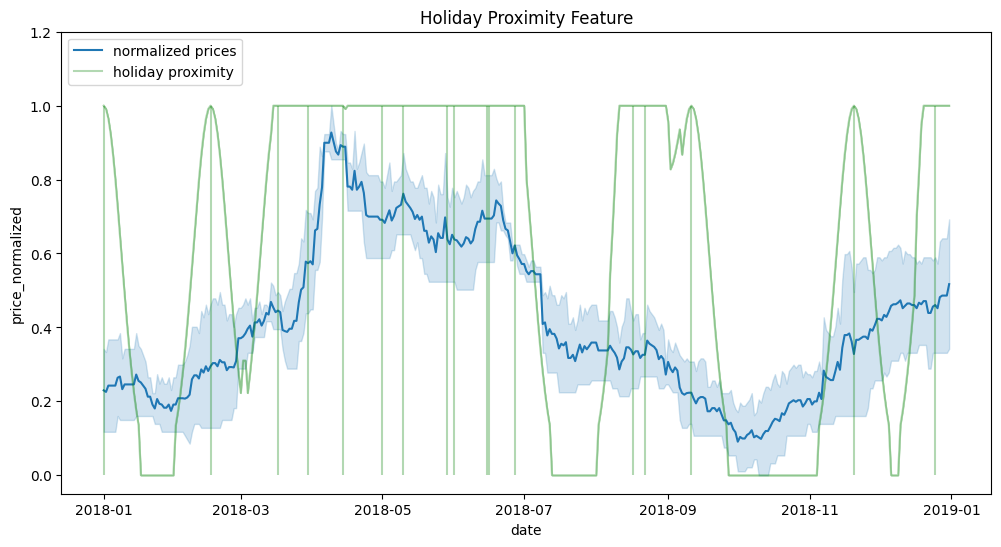

In [22]:
# We can plot the holiday proximity feature in the year 2018 for sanity check
plt.figure(figsize=(12, 6))

plot_data = feat_df[feat_df["date"] < "2019"].copy()
plot_holiday_dates = holiday_dates[holiday_dates < pd.to_datetime("2019")]

# Normalize the prices to (0, 1) to match the value range of holiday proximity
min, max = plot_data["price"].min(), plot_data["price"].max()
plot_data["price_normalized"] = (plot_data["price"] - min) / (max - min)

# Plot the prices
sns.lineplot(plot_data, x="date", y="price_normalized", label="normalized prices")

# Plot the time features
sns.lineplot(plot_data, x="date", y="feath_proximity",
             label="holiday proximity", color="green", alpha=0.3)
for date in plot_holiday_dates:
    plt.vlines(x=date, ymin=0, ymax=1, color="green", alpha=0.3)

plt.ylim(top=1.2)
plt.title("Holiday Proximity Feature")
plt.legend(loc="upper left")
plt.show()

As we can see, the holiday proximity feature has been calculated as expected.

## Weather features

An additional feature that could improve our shallot price forecasting model is weather data.

Shallot farming is typically done during the **dry season**, making weather parameters such as average precipitation, daylight duration, and temperature potentially useful in forecasting prices.

However, for simplicity in this project, it is crucial to ensure that these weather parameters are **available during the prediction phase**. Therefore, this project will use the **one-month average of the previous year's weather data** as a feature. This is based on the assumption that last year's weather conditions will be similar to those of the current year.

The weather data is obtained from the free and open-sourced weather API [Open-Meteo](https://open-meteo.com/). We retrieve daily weather data by targeting the locations of several cities across East Java and aggregating the results by calculating the mean value.

In [23]:
# Retrieve the weather data which includes precipitation, daylight duration, and temperature
weather_df = download_csv_from_gcs(bucket, WEATHER_CSV, ["date"])
weather_df.set_index("date", inplace=True)

weather_columns = ["featw_temperature_c", "featw_dayligh_duration_h",
                   "featw_precipitation_sum_mm"]
weather_df.columns = weather_columns

In [24]:
weather_df.head()

featw_temperature_c  featw_dayligh_duration_h  \
date                                                        
2016-01-01                26.84                   45205.0   
2016-01-02                26.71                   45198.0   
2016-01-03                26.58                   45191.0   
2016-01-04                26.29                   45183.0   
2016-01-05                26.65                   45175.0   

            featw_precipitation_sum_mm  
date                                    
2016-01-01                        6.58  
2016-01-02                        5.81  
2016-01-03                        9.48  
2016-01-04                        7.10  
2016-01-05                        2.52

In [25]:
weather_df["month"] = weather_df.index.month
weather_df["year"] = weather_df.index.year

# Calculate the monthly average of the weather condition
monthly_avg_weather = weather_df.groupby(["year", "month"]).mean().round(2)
monthly_avg_weather = monthly_avg_weather.reset_index()

In [26]:
monthly_avg_weather.head()

year  month  featw_temperature_c  featw_dayligh_duration_h  \
0  2016      1                26.68                  45029.48   
1  2016      2                25.97                  44449.52   
2  2016      3                26.75                  43705.45   
3  2016      4                26.71                  42960.70   
4  2016      5                26.97                  42360.16   

   featw_precipitation_sum_mm  
0                        7.85  
1                       17.58  
2                        9.03  
3                        7.18  
4                        4.27

In [27]:
# Helper function

def get_last_year_weather(row, weather_data):
    """ A function to return the last year month-averaged weather data. """

    month = row["date"].month
    last_year = row["date"].year - 1

    weather_last_year = weather_data[(weather_data["year"] == last_year) &
                                     (weather_data["month"] == month)]

    return weather_last_year.iloc[0]

In [28]:
for col in weather_columns:
    feat_df[col] = feat_df.apply(
                      lambda row: get_last_year_weather(row, monthly_avg_weather)[col],
                      axis=1
                  )

In [57]:
# We also normalize the weather features to (0, 1)
for c in weather_columns:
    min, max = feat_df[c].min(), feat_df[c].max()
    feat_df[c] = (feat_df[c] - min) /  (max - min)

Finally, we can summarize all the additional features that we gather for the shallot prices prediction.

In [58]:
FEAT_COLS = sorted([c for c in feat_df.columns if "feat" in c])

In [59]:
print("Additional features:")
for c in FEAT_COLS: print(f"\t{c}")

Additional features:
	featd_dayofyear_cos
	featd_dayofyear_sin
	feath_proximity
	featw_dayligh_duration_h
	featw_precipitation_sum_mm
	featw_temperature_c


In [60]:
feat_df = feat_df[["data_split", "date", "regions", "price"] + FEAT_COLS]

In [61]:
feat_df.head()

data_split       date    regions  price  featd_dayofyear_cos  \
0      TRAIN 2018-01-01  mojokerto  14750             0.999852   
1      TRAIN 2018-01-02  mojokerto  14750             0.999407   
2      TRAIN 2018-01-03  mojokerto  14750             0.998667   
3      TRAIN 2018-01-04  mojokerto  14750             0.997630   
4      TRAIN 2018-01-05  mojokerto  14750             0.996298   

   featd_dayofyear_sin  feath_proximity  featw_dayligh_duration_h  \
0             0.017213         1.000000                  0.941306   
1             0.034422         0.991151                  0.941306   
2             0.051620         0.965069                  0.941306   
3             0.068802         0.923116                  0.941306   
4             0.085965         0.867428                  0.941306   

   featw_precipitation_sum_mm  featw_temperature_c  
0                    0.826446             0.159468  
1                    0.826446             0.159468  
2                    0.826446             0.159468  
3                    0.826446             0.159468  
4                    0.826446             0.159468

Now we are ready to try AutoML tools!

# AutoTS

---



The first AutoML tools is AutoTS. Its unique features include a flexible model selection process that encompasses a wide range of algorithms, such as ARIMA and advanced deep learning models, along with the use of genetic algorithms for optimizing model and hyperparameter selection. Additionally, AutoTS supports advanced techniques like ensemble methods and quantile forecasting.

In [33]:
from autots import AutoTS

IS_AUTOTS_TRAIN = True

AutoTS is well integrated with Pandas, so we don't need to transform our dataset in any specific way.

In [62]:
train_set = feat_df[feat_df["data_split"].isin(["TRAIN", "VALIDATE"])].copy()

In [63]:
unique_region = feat_df["regions"].unique()
unique_region

array(['mojokerto', 'surabaya'], dtype=object)

We also define the feature weights for our forecasting model, including the additional features.

In [64]:
weights = { c: 1 for c in FEAT_COLS }
weights["price"] = 10
weights

{'featd_dayofyear_cos': 1,
 'featd_dayofyear_sin': 1,
 'feath_proximity': 1,
 'featw_dayligh_duration_h': 1,
 'featw_precipitation_sum_mm': 1,
 'featw_temperature_c': 1,
 'price': 10}

Below are the AutoTS model parameters. Note that we specifically choose `model_list="probabilistic"` because we want models that can estimate uncertainty and provide prediction intervals. As of this writing, AutoTS supports 27 probabilistic models, the details of which can be found [here](https://winedarksea.github.io/AutoTS/build/html/source/tutorial.html#id10). We also set `prediction_interval=0.90` to enable quantile forecasting.

The other parameters like `max_generations=4`, `transformer_list="superfast"`, and are chosen to speed up training.

In [65]:
model_autots = AutoTS(
    forecast_length=15,
    frequency="D",
    ensemble="horizontal-max", # more robust ensembles
    max_generations=5,
    model_list="probabilistic",
    transformer_list="superfast",
    num_validations=2,
    validation_method="similarity",
    no_negatives=True,
    constraint=2.0, # max(training data) + 2.0 * st.dev(training data)
    prediction_interval=0.95,
)

Using 1 cpus for n_jobs.


In [ ]:
if IS_AUTOTS_TRAIN:
    start_time = time.time()
    model_autots.fit(train_set,
                     date_col="date",
                     value_col="price",
                     id_col="regions",
                     weights=weights
    )
    end_time = time.time()

In [67]:
elapsed_time = end_time - start_time
print(f"Elapsed time for AutoTS training: {elapsed_time:.2f} seconds")
print(f"Best model: {model_autots.best_model_name}")

Elapsed time for AutoTS training: 2024.11 seconds
Best model: Ensemble


In [68]:
AUTOTS_PRED = "predictions_autots.csv"

if IS_AUTOTS_TRAIN:
    # Predict prices
    prediction = model_autots.predict()

    # Format the predicted prices from wide to long table merging the regions
    # into one column.
    predictions = prediction.forecast.reset_index()
    predictions = predictions.melt(id_vars="index", value_vars=unique_region,
                                   var_name="regions", value_name="prediction")
    predictions = predictions.rename(columns={"index": "date"})

    # Since we define 'model_list="probabilistic"' and 'prediction_interval=0.90',
    # AutoTS provide `lower_forecast` and `upper_forecast`.
    # The `lower_forecast` in this case corresponds to the prediction at the 10% quantile.
    lower_predictions = prediction.lower_forecast.reset_index()
    lower_predictions = lower_predictions.melt(id_vars="index", value_vars=unique_region,
                                               var_name="regions", value_name="0.1")
    lower_predictions = lower_predictions.rename(columns={"index": "date"})

    # Meanwhile, the `upper_forecast` in this case corresponds to the prediction
    # at the 90% quantile.
    upper_predictions = prediction.upper_forecast.reset_index()
    upper_predictions = upper_predictions.melt(id_vars="index", value_vars=unique_region,
                                               var_name="regions", value_name="0.9")
    upper_predictions = upper_predictions.rename(columns={"index": "date"})

    predictions_autots = pd.merge(predictions,
                                  pd.merge(lower_predictions,
                                           upper_predictions,
                                           on=['date', 'regions']),
                                  on=['date', 'regions'])

    upload_csv_to_gcs(predictions_autots, bucket, AUTOTS_PRED)
else:
    predictions_autots = download_csv_from_gcs(bucket, AUTOTS_PRED)


None
[{'constraint_method': 'stdev_min', 'constraint_value': 2.0, 'constraint_direction': 'upper', 'constraint_regularization': 1, 'bounds': False}, {'constraint_method': 'stdev_min', 'constraint_value': 2.0, 'constraint_direction': 'lower', 'constraint_regularization': 1, 'bounds': False}]
None
[{'constraint_method': 'stdev_min', 'constraint_value': 2.0, 'constraint_direction': 'upper', 'constraint_regularization': 1, 'bounds': False}, {'constraint_method': 'stdev_min', 'constraint_value': 2.0, 'constraint_direction': 'lower', 'constraint_regularization': 1, 'bounds': False}]
Successfully uploaded: 'predictions_autots.csv' to 'commodity_prices_automl'


In [69]:
predictions_autots.head()

date    regions  prediction       0.1        0.9
0 2024-07-17  mojokerto     22462.0  21984.50  23655.750
1 2024-07-18  mojokerto     22462.0  21425.75  25262.000
2 2024-07-19  mojokerto     22962.0  21425.75  25808.875
3 2024-07-20  mojokerto     23462.0  21268.25  25808.875
4 2024-07-21  mojokerto     22712.0  21268.25  25668.250

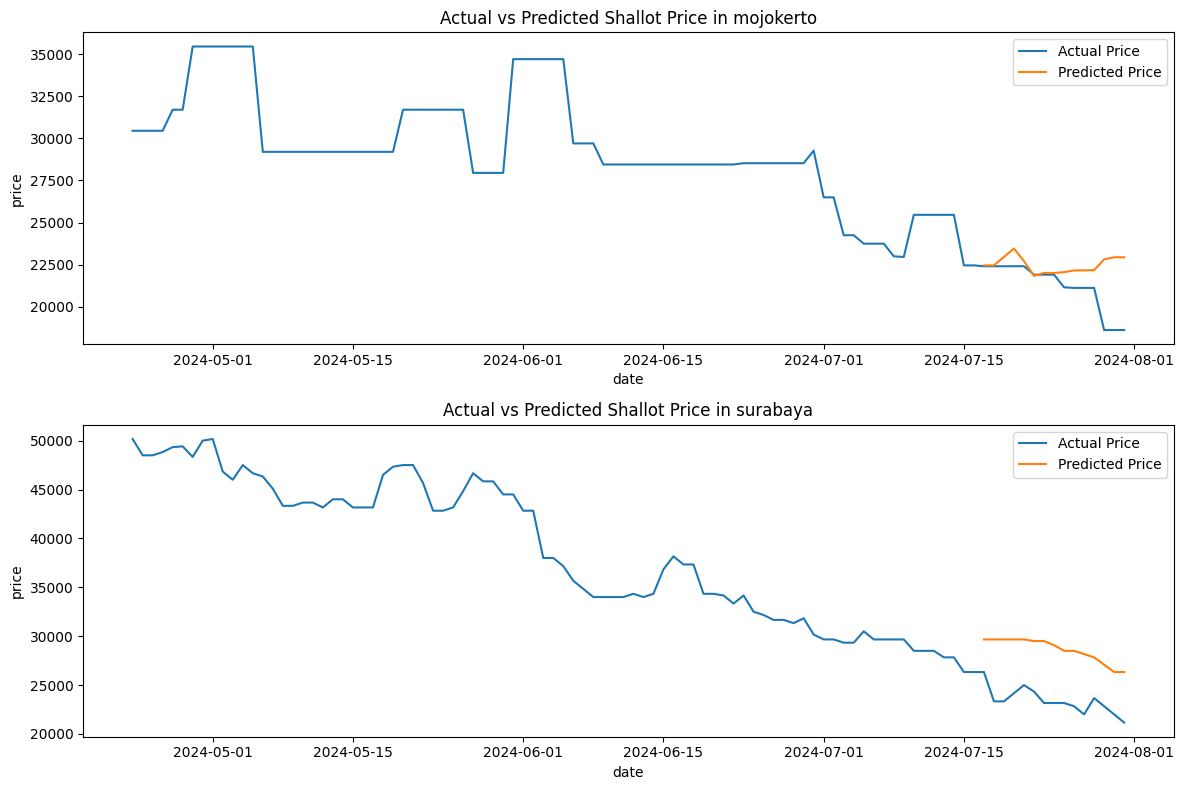

In [70]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

for i, region in enumerate(unique_region):

    actual_price = feat_df[feat_df["regions"] == region].iloc[-100:]
    predicted_price = predictions_autots[predictions_autots["regions"] == region]

    sns.lineplot(actual_price, x="date", y="price", ax=ax[i], label="Actual Price")

    sns.lineplot(predicted_price, x="date", y="prediction", ax=ax[i], label="Predicted Price")

    ax[i].set_title(f"Actual vs Predicted Shallot Price in {region}")
    ax[i].legend(loc="upper right")

plt.tight_layout()
plt.show()